In [18]:
#!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk@11/libexec/openjdk.jdk/Contents/Home"


In [19]:
import json
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [20]:
spark = SparkSession.builder.appName("CommunityRDD").getOrCreate()
sc = spark.sparkContext

In [21]:
json_file_path = '../Community Detection/10K.json'
with open(json_file_path, 'r') as f:
    community_data = json.load(f)

In [22]:
#community_data_with_ids = add_community_id(community_data)
community_rdd = sc.parallelize(community_data)
type(community_rdd)
print(community_rdd.take(5))

[{'community_id': 1, 'nodes': [371, 340, 378, 667, 974, 368, 627, 64, 168, 257, 925, 767, 549, 890, 899, 226, 45, 71, 72, 381, 707, 973, 812, 839, 96, 433, 670, 468, 466, 876, 402, 646, 593, 366, 612], 'edges': [{'node1': 371, 'node2': 549, 'begintijd': 20240318013535, 'eindtijd': 20240318030219}, {'node1': 371, 'node2': 812, 'begintijd': 20240412020025, 'eindtijd': 20240412053609}, {'node1': 371, 'node2': 670, 'begintijd': 20240606074446, 'eindtijd': 20240606110610}, {'node1': 340, 'node2': 378, 'begintijd': 20240918161950, 'eindtijd': 20240918172041}, {'node1': 378, 'node2': 466, 'begintijd': 20240918071254, 'eindtijd': 20240918140257}, {'node1': 667, 'node2': 767, 'begintijd': 20241101133614, 'eindtijd': 20241101175233}, {'node1': 368, 'node2': 627, 'begintijd': 20240112043512, 'eindtijd': 20240112122716}, {'node1': 368, 'node2': 767, 'begintijd': 20240205225900, 'eindtijd': 20240206062846}, {'node1': 64, 'node2': 627, 'begintijd': 20240407064043, 'eindtijd': 20240407074414}, {'node

In [23]:
#Create a key-value RDD where key = community_id, value = nodes and edges
community_kv_rdd = community_rdd.map(lambda community: (community['community_id'], {
    'nodes': community['nodes'], 
    'edges': community['edges']
}))

type(community_kv_rdd)

pyspark.rdd.PipelinedRDD

In [24]:
#!pip install netrd


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import networkx as nx
from netrd.distance import NetSimile

In [28]:
#!pip install findspark


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
import findspark
findspark.init()

In [31]:
###TemporalNetSimile defintion
"""
Temporalnetsimile.py
--------------

Graph distance based on:
Berlingerio, M., Koutra, D., Eliassi-Rad, T. & Faloutsos, C. NetSimile: A Scalable Approach to Size-Independent Network Similarity. arXiv (2012)

Extended upon netsimile.py, acreditted to:

author: Alex Gates
email: ajgates42@gmail.com (optional)
Submitted as part of the 2019 NetSI Collabathon.
https://netrd.readthedocs.io/en/latest/_modules/netrd/distance/netsimile.html

We wish to note that extensions upon the initial netsimile code is preceded by a ###comment

"""

import networkx as nx
import numpy as np
from scipy.spatial.distance import canberra
from scipy.stats import skew, kurtosis

from netrd.distance.base import BaseDistance
from netrd.utilities import undirected, unweighted

###Needed to convert time later
from datetime import datetime


class TemporalNetSimile(BaseDistance):
    """Compares node signature distributions."""


    @undirected
    @unweighted
    def dist(self, G1, G2):
        """A scalable approach to network similarity.

        A network similarity measure based on node signature distributions.
        
        The results dictionary includes the underlying feature matrices in
        `'feature_matrices'` and the underlying signature vectors in
        `'signature_vectors'`.

        Parameters
        ----------

        G1, G2 (nx.Graph)
            two undirected networkx graphs to be compared.

        Returns
        -------

        dist (float)
            the distance between `G1` and `G2`.

        References
        ----------

        .. [1] Michele Berlingerio, Danai Koutra, Tina Eliassi-Rad,
               Christos Faloutsos: NetSimile: A Scalable Approach to
               Size-Independent Network Similarity. CoRR abs/1209.2684
               (2012)

        """

        # find the graph node feature matrices
        G1_node_features = feature_extraction(G1)
        G2_node_features = feature_extraction(G2)

        # get the graph signature vectors
        G1_signature = graph_signature(G1_node_features)
        G2_signature = graph_signature(G2_node_features)

        # the final distance is the absolute canberra distance
        dist = abs(canberra(G1_signature, G2_signature))

        ###Remove for quicker comp.
        ###self.results['feature_matrices'] = G1_node_features, G2_node_features
        ###self.results['signature_vectors'] = G1_signature, G2_signature
        
        self.results['dist'] = dist

        return dist



def feature_extraction(G):
    """Node feature extraction.

    Parameters
    ----------

    G (nx.Graph): a networkx graph.

    Returns
    -------

    node_features (float): the Nx7 matrix of node features."""

    # necessary data structures
    ###FEATURE NUMBER
    node_features = np.zeros(shape=(G.number_of_nodes(), 10)) 
    node_list = sorted(G.nodes())
    node_degree_dict = dict(G.degree())
    node_clustering_dict = dict(nx.clustering(G))
    egonets = {n: nx.ego_graph(G, n) for n in node_list}

    # node degrees
    degs = [node_degree_dict[n] for n in node_list]

    # clustering coefficient
    clusts = [node_clustering_dict[n] for n in node_list]

    # average degree of neighborhood
    neighbor_degs = [
        np.mean([node_degree_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # average clustering coefficient of neighborhood
    neighbor_clusts = [
        np.mean([node_clustering_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # number of edges in the neighborhood
    neighbor_edges = [
        egonets[n].number_of_edges() if node_degree_dict[n] > 0 else 0
        for n in node_list
    ]

    # number of outgoing edges from the neighborhood
    # the sum of neighborhood degrees = 2*(internal edges) + external edges
    # node_features[:,5] = node_features[:,0] * node_features[:,2] - 2*node_features[:,4]
    neighbor_outgoing_edges = [
        len(
            [
                edge
                for edge in set.union(*[set(G.edges(j)) for j in egonets[i].nodes])
                if not egonets[i].has_edge(*edge)
            ]
        )
        for i in node_list
    ]

    # number of neighbors of neighbors (not in neighborhood)
    neighbors_of_neighbors = [
        len(
            set([p for m in G.neighbors(n) for p in G.neighbors(m)])
            - set(G.neighbors(n))
            - set([n])
        )
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    ###Temporal features on the edges

    ###start time, average start time of the edges of a single node
    ###Loop over all nodes, look at the starttime data from the edges, convert the time to time format, calculate mean start time for each node
    startTime = []
    for n in node_list:
        start_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            start_time_str = str(data['begintijd'])
            start_time = datetime.strptime(start_time_str, '%Y%m%d%H%M%S')
            start_times.append(start_time.timestamp())  # Store as timestamp (seconds since epoch)

        startTime.append(np.mean(start_times) if start_times else 0)

    ###end time, average end time of the edges of a single node
    ###Loop over all nodes, look at the endtime data from the edges, convert the time to time format, calculate mean end time for each node
    endTime = []
    for n in node_list:
        end_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            end_time_str = str(data['eindtijd'])
            end_time = datetime.strptime(end_time_str, '%Y%m%d%H%M%S')
            end_times.append(end_time.timestamp())  # Store as timestamp (seconds since epoch)

        endTime.append(np.mean(end_times) if end_times else 0)
    
    ###duration, average duration of the edges of a single node
    duration = []
    for n in node_list:
        duration.append(endTime[node_list.index(n)] - startTime[node_list.index(n)])
    ### end change

    # assembling the features
    node_features[:, 0] = degs
    node_features[:, 1] = clusts
    node_features[:, 2] = neighbor_degs
    node_features[:, 3] = neighbor_clusts
    node_features[:, 4] = neighbor_edges
    node_features[:, 5] = neighbor_outgoing_edges
    node_features[:, 6] = neighbors_of_neighbors

    ###Time features
    node_features[:, 7] = startTime
    node_features[:, 8] = endTime
    node_features[:, 9] = duration

    return np.nan_to_num(node_features)


def graph_signature(node_features):
    ###FEATURE NUMBER
    signature_vec = np.zeros(10 * 5)

    # for each of the features
    ### FEATURE NUMBER
    for k in range(10):
        # find the mean
        signature_vec[k * 5] = node_features[:, k].mean()
        # find the median
        signature_vec[k * 5 + 1] = np.median(node_features[:, k])
        # find the std
        signature_vec[k * 5 + 2] = node_features[:, k].std()
        # find the skew
        signature_vec[k * 5 + 3] = skew(node_features[:, k])
        # find the kurtosis
        signature_vec[k * 5 + 4] = kurtosis(node_features[:, k])

    return signature_vec


"""
# sample usage
>>>G1 = nx.karate_club_graph()
>>>G2 = nx.krackhardt_kite_graph()

>>>test = TemporalNetSimile()
>>>print(test.dist(G1, G2))
11.45
"""

'\n# sample usage\n>>>G1 = nx.karate_club_graph()\n>>>G2 = nx.krackhardt_kite_graph()\n\n>>>test = TemporalNetSimile()\n>>>print(test.dist(G1, G2))\n11.45\n'

In [32]:

#Based on outcome of above, this is rough sketch of how I would envision it
# Get data from two communities
def Compare(Community1, Community2):
    #Convert into networkX graph to use as input for TemportalNetSimile
    #Load Graphs
    Graph1 = nx.Graph()
    Graph1.add_nodes_from(Community1["nodes"])

    # Add edges with timestamps as edge attributes
    for edge in Community1["edges"]:
        Graph1.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    Graph2=nx.Graph()
    Graph2.add_nodes_from(Community2["nodes"])
    for edge in Community2["edges"]:
        Graph2.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    testTime=TemporalNetSimile()
    Similarity = testTime.dist(Graph1, Graph2)
    return(Similarity)

#print(Compare(Community1,Community2))

In [33]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# show all rows with df.head
pd.options.display.max_columns = None
# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
pairs_rdd = community_rdd.cartesian(community_rdd).filter(lambda pair: str(pair[0]) < str(pair[1]))

#Calculate Distance
results_rdd = pairs_rdd.map(lambda pair: (pair, Compare(pair[0], pair[1])))

#Print
results = results_rdd.collect()

# Collect the results into a list of tuples (community_id1, community_id2, distance)
similarities = []

for pair, comparison_result in results:
    community_id1 = pair[0]['community_id']
    community_id2 = pair[1]['community_id']
    distance = comparison_result
    similarities.append((community_id1, community_id2, distance))

# Optionally, print the collected similarities
print("Collected Similarities:")
for sim in similarities:
    print(f"Community {sim[0]} and Community {sim[1]}: Distance = {sim[2]}")

/var/folders/kr/m4s8zyfs4_xg9wqy_3tf3xxw0000gn/T/ipykernel_99303/2937066106.py:230: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/var/folders/kr/m4s8zyfs4_xg9wqy_3tf3xxw0000gn/T/ipykernel_99303/2937066106.py:232: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/var/folders/kr/m4s8zyfs4_xg9wqy_3tf3xxw0000gn/T/ipykernel_99303/2937066106.py:230: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
/var/folders/kr/m4s8zyfs4_xg9wqy_3tf3xxw0000gn/T/ipykernel_99303/2937066106.py:232: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results

Collected Similarities:
Community 1 and Community 2: Distance = 9.346764792687686
Community 1 and Community 3: Distance = 8.62705576202998
Community 1 and Community 4: Distance = 9.510603111137561
Community 1 and Community 5: Distance = 7.731213352547465
Community 1 and Community 6: Distance = 6.0653778155218
Community 2 and Community 3: Distance = 10.571663007569715
Community 2 and Community 4: Distance = 7.929397436928702
Community 2 and Community 5: Distance = 11.043764455779888
Community 2 and Community 6: Distance = 9.250231758249225
Community 3 and Community 4: Distance = 11.029139052365556
Community 3 and Community 5: Distance = 8.956084310264387
Community 3 and Community 6: Distance = 7.402211814471928
Community 4 and Community 5: Distance = 8.951109272366631
Community 4 and Community 6: Distance = 7.93578998482756
Community 5 and Community 6: Distance = 6.1108268256519285
Community 1 and Community 7: Distance = 8.980422394812285
Community 1 and Community 8: Distance = 9.577040

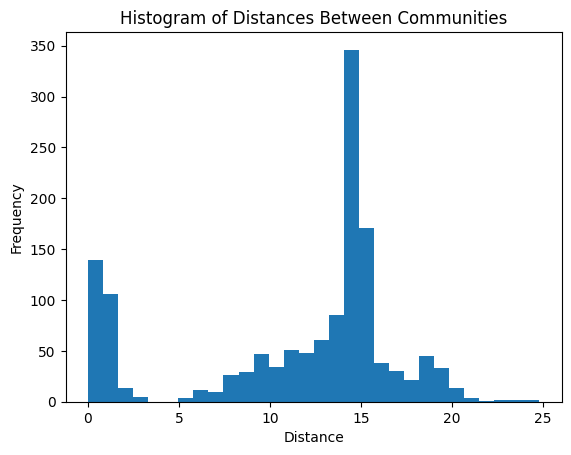

In [35]:
import matplotlib.pyplot as plt

# Extract distances for analysis
distances = [distance for _, _, distance in similarities]

# Plot histogram of distances
plt.hist(distances, bins=30)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances Between Communities')
plt.show()

In [36]:
# Calculate mean and standard deviation
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Set threshold at one standard deviation below the mean
threshold = mean_distance - std_distance
print(threshold)

5.692749262868561


In [ ]:
#From the histogram we can see a gap around distance of 5. 
threshold = 5.0

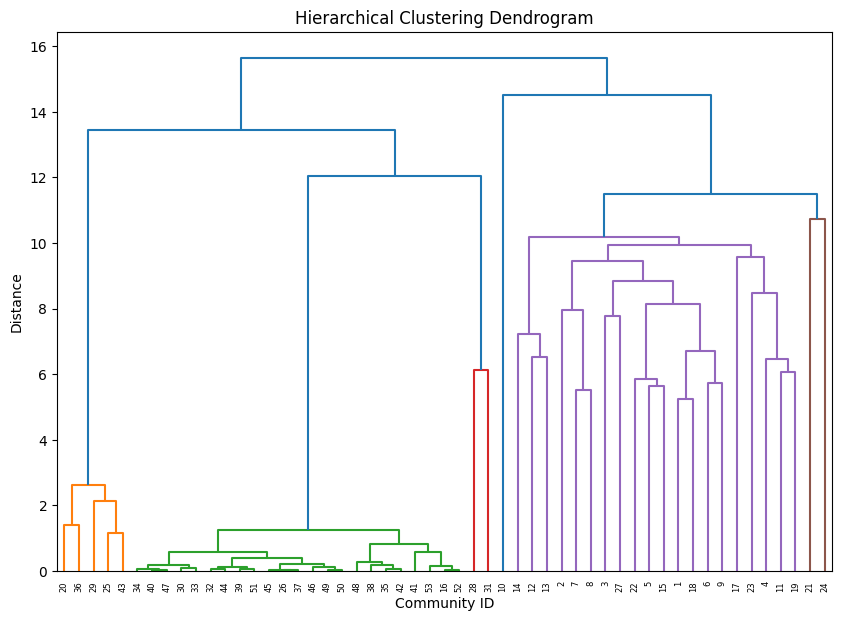


Groups of Similar Communities (Hierarchical Clustering):
Group 7: [1, 5, 6, 9, 15, 18, 22]
Group 5: [2, 7, 8]
Group 6: [3, 27]
Group 8: [4, 11, 19, 23]
Group 12: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 9: [17]
Group 1: [20, 25, 29, 36, 43]
Group 10: [21]
Group 11: [24]
Group 3: [28, 31]


24/11/06 19:46:45 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1897498 ms exceeds timeout 120000 ms
24/11/06 19:46:45 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/06 19:46:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [58]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

# Assume 'similarities' is your list of (community_id1, community_id2, distance)
community_ids = sorted(set([id for sim in similarities for id in sim[:2]]))
id_to_index = {id: idx for idx, id in enumerate(community_ids)}
N = len(community_ids)

# Initialize a full distance matrix with zeros
distance_matrix = np.zeros((N, N))

# Fill in the distances
for community_id1, community_id2, distance in similarities:
    i, j = id_to_index[community_id1], id_to_index[community_id2]
    distance_matrix[i, j] = distance
    distance_matrix[j, i] = distance  # Symmetric matrix

# Convert to condensed distance matrix required for linkage
condensed_dists = squareform(distance_matrix)

# Perform hierarchical clustering
Z = linkage(condensed_dists, method='average')

# Plot the dendrogram (optional)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=community_ids)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Community ID')
plt.ylabel('Distance')
plt.show()

# Choose a threshold based on the dendrogram
threshold = 8.5  # Adjust as necessary

# Get cluster labels
cluster_labels = fcluster(Z, t=threshold, criterion='distance')

# Group communities by cluster labels
groups = defaultdict(list)
for community_id, cluster_label in zip(community_ids, cluster_labels):
    groups[cluster_label].append(community_id)

# Output the groups
print("\nGroups of Similar Communities (Hierarchical Clustering):")
for cluster_label, community_list in groups.items():
    print(f"Group {cluster_label}: {sorted(community_list)}")


[[ 0.          9.34676479  8.62705576 ... 14.38404999 15.49827785
  15.58070304]
 [ 9.34676479  0.         10.57166301 ... 14.57154454 15.59822246
  15.67906802]
 [ 8.62705576 10.57166301  0.         ... 14.25023671 15.35715553
  15.43080407]
 ...
 [14.38404999 14.57154454 14.25023671 ...  0.          1.19071875
   1.28324224]
 [15.49827785 15.59822246 15.35715553 ...  1.19071875  0.
   0.16436168]
 [15.58070304 15.67906802 15.43080407 ...  1.28324224  0.16436168
   0.        ]]


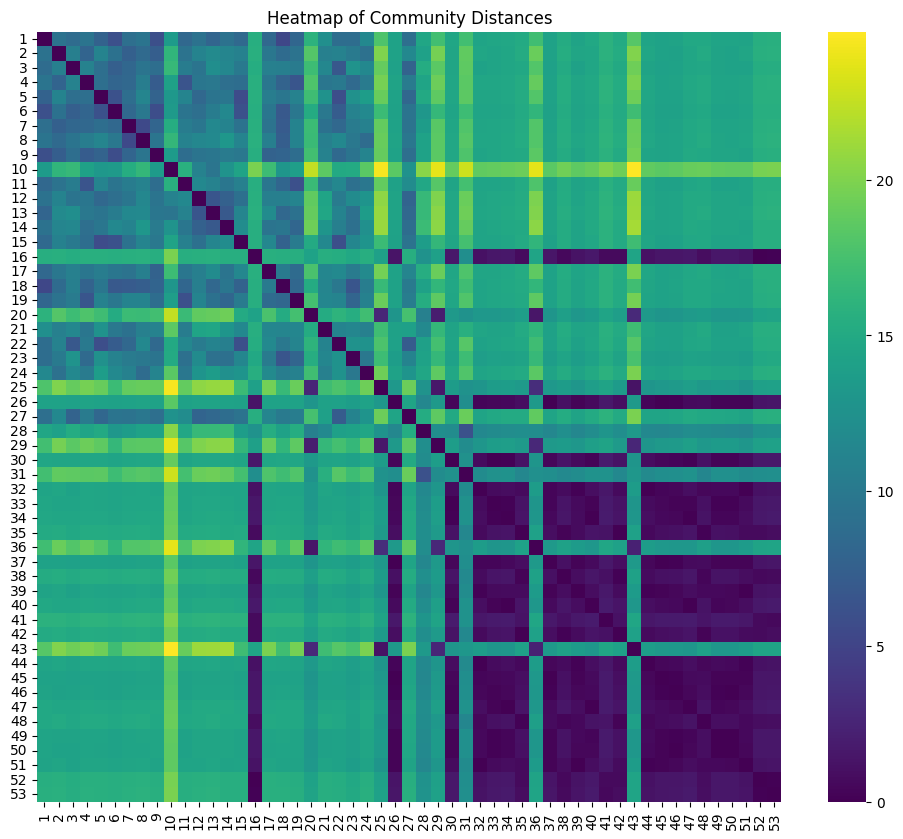

In [51]:
print(distance_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(distance_matrix, xticklabels=community_ids, yticklabels=community_ids, cmap='viridis')
plt.title('Heatmap of Community Distances')
plt.show()

In [52]:
min_distance = np.min(distances)
max_distance = np.max(distances)
mean_distance = np.mean(distances)
median_distance = np.median(distances)
print(f"Min Distance: {min_distance}")
print(f"Max Distance: {max_distance}")
print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")


Min Distance: 0.016849063604070257
Max Distance: 24.77347356300174
Mean Distance: 11.492310520010651
Median Distance: 14.160732847911753


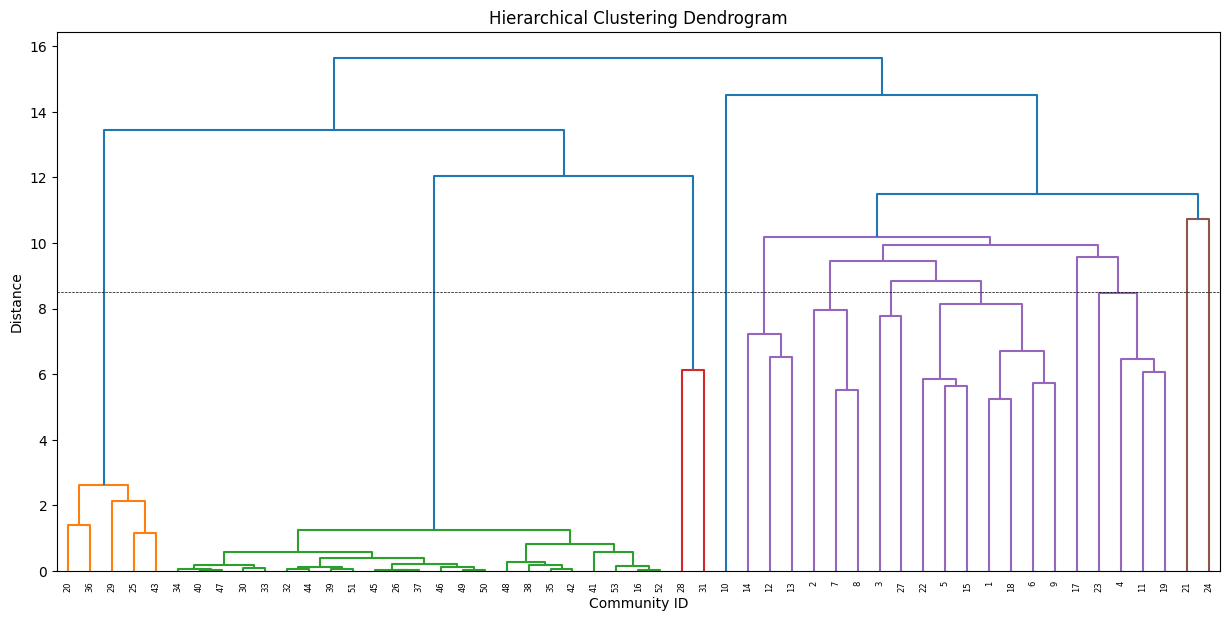

In [53]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(15, 7))
dendrogram(Z, labels=community_ids, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Community ID')
plt.ylabel('Distance')
plt.axhline(y=threshold, c='k', ls='--', lw=0.5)
plt.show()


In [54]:
linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    Z = linkage(condensed_dists, method=method)
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')

    # Group communities
    groups = defaultdict(list)
    for community_id, cluster_label in zip(community_ids, cluster_labels):
        groups[cluster_label].append(community_id)

    # Output the groups for each method
    print(f"\nLinkage Method: {method}")
    for cluster_label, community_list in groups.items():
        print(f"Group {cluster_label}: {sorted(community_list)}")



Linkage Method: single
Group 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 22, 23, 27]
Group 4: [10]
Group 5: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 6: [20, 25, 29, 36, 43]
Group 3: [21]
Group 2: [24]
Group 7: [28, 31]

Linkage Method: complete
Group 9: [1, 6, 9, 18]
Group 10: [2, 7, 8]
Group 6: [3, 27]
Group 11: [4, 11, 19]
Group 5: [5, 15, 22]
Group 14: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 13: [17]
Group 1: [20, 25, 29, 36, 43]
Group 7: [21]
Group 12: [23]
Group 8: [24]
Group 3: [28, 31]

Linkage Method: average
Group 7: [1, 5, 6, 9, 15, 18, 22]
Group 5: [2, 7, 8]
Group 6: [3, 27]
Group 8: [4, 11, 19, 23]
Group 12: [10]
Group 4: [12, 13, 14]
Group 2: [16, 26, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Group 9: [17]
Group 1: [20, 25, 29, 36, 43]
Group 10: [21]
Group 11: [